<a href="https://colab.research.google.com/github/dangogit/ML_HW3/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import PIL

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz

--2022-06-27 08:29:34--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  11.4MB/s    in 30s     

2022-06-27 08:30:06 (10.8 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2022-06-27 08:30:06--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203577493 (194M) [application/x-gzip]
Saving to: ‘102segmentations.tgz’

102segmentations.tg 100%[===================>] 194.15M  11.2MB/s    in 19s     

2022-06-27 08:

In [ ]:
!tar -xvf  '102flowers.tgz'

!tar -xvf  '102segmentations.tgz'

Streaming output truncated to the last 5000 lines.
segmim/segmim_02001.jpg
segmim/segmim_06248.jpg
segmim/segmim_07436.jpg
segmim/segmim_07409.jpg
segmim/segmim_06781.jpg
segmim/segmim_02394.jpg
segmim/segmim_05732.jpg
segmim/segmim_01096.jpg
segmim/segmim_02423.jpg
segmim/segmim_01421.jpg
segmim/segmim_02292.jpg
segmim/segmim_01972.jpg
segmim/segmim_07569.jpg
segmim/segmim_04956.jpg
segmim/segmim_03799.jpg
segmim/segmim_08141.jpg
segmim/segmim_06048.jpg
segmim/segmim_01065.jpg
segmim/segmim_07591.jpg
segmim/segmim_04813.jpg
segmim/segmim_05567.jpg
segmim/segmim_05523.jpg
segmim/segmim_00086.jpg
segmim/segmim_07378.jpg
segmim/segmim_01710.jpg
segmim/segmim_08030.jpg
segmim/segmim_03603.jpg
segmim/segmim_07303.jpg
segmim/segmim_00403.jpg
segmim/segmim_01079.jpg
segmim/segmim_01920.jpg
segmim/segmim_08041.jpg
segmim/segmim_00906.jpg
segmim/segmim_04960.jpg
segmim/segmim_00034.jpg
segmim/segmim_05586.jpg
segmim/segmim_02560.jpg
segmim/segmim_00634.jpg
segmim/segmim_02748.jpg
segmim/segmim

In [ ]:
import scipy.io
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

labels = np.array(scipy.io.loadmat('imagelabels.mat')['labels'])[0]

for img in os.listdir('jpg'):
  img_idx = img.split('_')[1].split('.')[0]
  label_idx = labels[int(img_idx)-1]

  if not os.path.exists(f'jpg/{label_idx}'):
    os.mkdir(f'jpg/{label_idx}')
  os.replace(f'jpg/{img}', f'jpg/{label_idx}/{img}')
  segment = img.replace('image', 'segmim')
  os.replace(f'segmim/{segment}', f'jpg/{label_idx}/{segment}')

--2022-06-27 08:33:03--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-06-27 08:33:05 (85.2 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [ ]:
!pip install split-folders
import splitfolders 
input_folder = "jpg"
output = "splited_jpg" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.5, .25, .25)) # ratio of split are in order of train/val/test. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 16378 files [00:03, 4568.72 files/s]


In [16]:
base_dir = 'splited_jpg'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [17]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# the validation/test data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [18]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 16, class_mode = 'categorical', target_size = (299, 299))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 16, class_mode = 'categorical', target_size = (299, 299))

# Flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir,  batch_size = 16, class_mode = 'categorical', target_size = (299, 299))

Found 8189 images belonging to 102 classes.
Found 4070 images belonging to 102 classes.
Found 4119 images belonging to 102 classes.


Very Deep Convolutional Networks for Large-Scale Image Recognition(VGG-16)


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (299, 299, 3), include_top = True, weights = None, classes=102)

In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

In [10]:
vgghist = model.fit(train_generator, validation_data=validation_generator, validation_steps=10, steps_per_epoch=10, epochs=10, workers=10, use_multiprocessing=True)


Epoch 1/10
10/10 [==============================] - 358s 37s/step - loss: 4.6248 - accuracy: 0.5770 - val_loss: 4.6246 - val_accuracy: 0.6539
Epoch 2/10
10/10 [==============================] - 312s 32s/step - loss: 4.6245 - accuracy: 0.5868 - val_loss: 4.6241 - val_accuracy: 0.7614
Epoch 3/10
10/10 [==============================] - 357s 37s/step - loss: 4.6242 - accuracy: 0.5756 - val_loss: 4.6237 - val_accuracy: 0.7721
Epoch 4/10
10/10 [==============================] - 319s 33s/step - loss: 4.6236 - accuracy: 0.6237 - val_loss: 4.6234 - val_accuracy: 0.8006
Epoch 5/10
10/10 [==============================] - 357s 37s/step - loss: 4.6236 - accuracy: 0.6348 - val_loss: 4.6232 - val_accuracy: 0.7960
Epoch 6/10
10/10 [==============================] - 365s 38s/step - loss: 4.6227 - accuracy: 0.6971 - val_loss: 4.6232 - val_accuracy: 0.7903
Epoch 7/10
10/10 [==============================] - 313s 32s/step - loss: 4.6223 - accuracy: 0.6669 - val_loss: 4.6208 - val_accuracy: 0.8027
Epoch 

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [15]:
pred = model.predict(test_generator, use_multiprocessing=True, workers=10)
pd.DataFrame(pred).to_csv('res_vgg.csv')

In [12]:
model.evaluate(test_generator, use_multiprocessing=True,workers=10)

258/258 [==============================] - 3811s 15s/step - loss: 4.6193 - accuracy: 0.7726


[4.61934757232666, 0.7726036906242371]

Inception

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(input_shape = (299, 299, 3), include_top = True, weights = None, classes=102)

In [21]:
for layer in base_model2.layers:
    layer.trainable = False

In [22]:
x = layers.Flatten()(base_model2.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.models.Model(base_model2.input, x)

model2.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

In [24]:
inc_history = model2.fit(train_generator, validation_data=validation_generator, validation_steps=10, steps_per_epoch=10, epochs=10, workers=10, use_multiprocessing=True)


Epoch 1/10
10/10 [==============================] - 85s 8s/step - loss: 4.6248 - accuracy: 0.7654 - val_loss: 4.6244 - val_accuracy: 0.9140
Epoch 2/10
10/10 [==============================] - 83s 8s/step - loss: 4.6235 - accuracy: 0.8860 - val_loss: 4.6233 - val_accuracy: 0.9527
Epoch 3/10
10/10 [==============================] - 85s 8s/step - loss: 4.6226 - accuracy: 0.9052 - val_loss: 4.6206 - val_accuracy: 0.9532
Epoch 4/10
10/10 [==============================] - 85s 8s/step - loss: 4.6208 - accuracy: 0.9184 - val_loss: 4.6212 - val_accuracy: 0.9336
Epoch 5/10
10/10 [==============================] - 85s 8s/step - loss: 4.6210 - accuracy: 0.9167 - val_loss: 4.6199 - val_accuracy: 0.9335
Epoch 6/10
10/10 [==============================] - 92s 9s/step - loss: 4.6179 - accuracy: 0.9300 - val_loss: 4.6176 - val_accuracy: 0.9147
Epoch 7/10
10/10 [==============================] - 85s 8s/step - loss: 4.6180 - accuracy: 0.9176 - val_loss: 4.6166 - val_accuracy: 0.9240
Epoch 8/10
10/10 [==

In [25]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [26]:
model2.evaluate(test_generator,use_multiprocessing=True,workers=10)

258/258 [==============================] - 906s 3s/step - loss: 4.6104 - accuracy: 0.9057


[4.610393524169922, 0.9057219624519348]

In [29]:
pred2 = model2.predict(test_generator,use_multiprocessing=True,workers=10)
pd.DataFrame(pred2).to_csv('res_inc.csv')

Results graphs

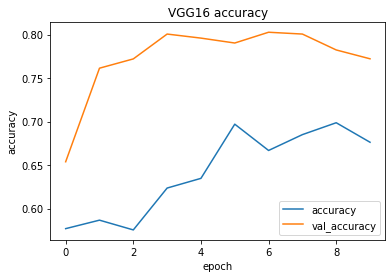

In [13]:
#Accuracy
plt.plot(vgghist.history['accuracy'],label='accuracy')
plt.plot(vgghist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

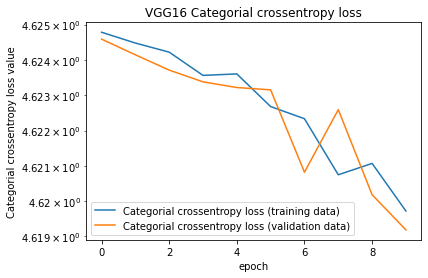

In [14]:
# Visualize training process
plt.plot(vgghist.history['loss'], label='Categorial crossentropy loss (training data)')
plt.plot(vgghist.history['val_loss'], label='Categorial crossentropy loss (validation data)')
plt.title('VGG16 Categorial crossentropy loss')
plt.ylabel('Categorial crossentropy loss value')
plt.yscale('log')
plt.xlabel('epoch')
plt.legend()
plt.show()

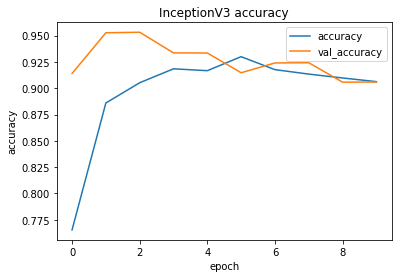

In [27]:
#Accuracy
plt.plot(inc_history.history['accuracy'],label='accuracy')
plt.plot(inc_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('InceptionV3 accuracy')
plt.show()

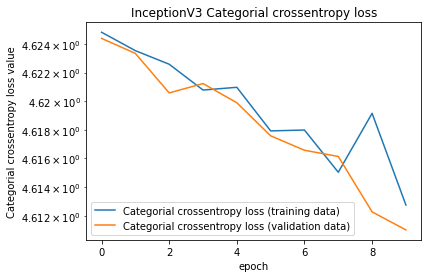

In [28]:
# Visualize training process
plt.plot(inc_history.history['loss'], label='Categorial crossentropy loss (training data)')
plt.plot(inc_history.history['val_loss'], label='Categorial crossentropy loss (validation data)')
plt.title('InceptionV3 Categorial crossentropy loss')
plt.ylabel('Categorial crossentropy loss value')
plt.yscale('log')
plt.xlabel('epoch')
plt.legend()
plt.show()